# Course Completion Prediction:
Given features derived from an online course platform, predict the likelihood that the given user completed their course in its entirety.

# Data Understanding

In [1]:
import pandas as pd

# Load the dataset
file_path = './../data/data.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,1,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,0,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,0,0


In [2]:
# Verify there are no missing values present in the dataset
df.isna().sum()

UserID                   0
CourseCategory           0
TimeSpentOnCourse        0
NumberOfVideosWatched    0
NumberOfQuizzesTaken     0
QuizScores               0
CompletionRate           0
DeviceType               0
CourseCompletion         0
dtype: int64

In [3]:
# Check whether there are any duplicate rows in the dataset
df.duplicated().value_counts()

False    8123
True      877
Name: count, dtype: int64

Looks like there are 877 duplicates that need to be dropped.

In [4]:
df = df.drop_duplicates()

# Data Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

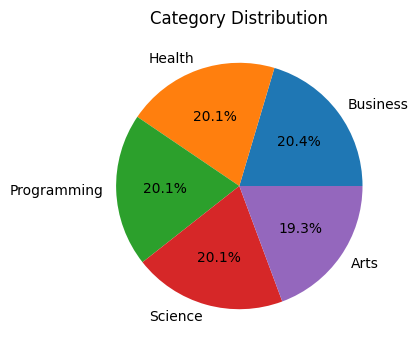

In [ ]:
values = df['CourseCategory'].value_counts()
values.plot(kind = 'pie', figsize = (6,6), autopct='%1.1f%%')
plt.title('Category Distribution')
plt.ylabel('')
plt.show()

Course categories are evenly distributed, so no rebalancing is needed.

count    8123.000000
mean       75.091084
std        14.339876
min        50.005119
25%        62.791226
50%        75.273913
75%        87.497542
max        99.994984
Name: QuizScores, dtype: float64

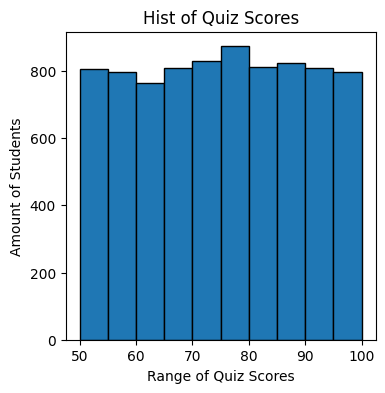

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(df['QuizScores'], bins=10, edgecolor='black')
plt.title('Hist of Quiz Scores')
plt.xlabel('Range of Quiz Scores')
plt.ylabel('Amount of Students')

df['QuizScores'].describe()

The range for quiz scores is almost equally distributed between 50% and 100%, but there seems to be no scores below 50%, and the description confirms it. For some reason zero people got a score below 50%. This is odd, and should be checked upstream. Assuming it's correct, we will continue for demonstration purposes.

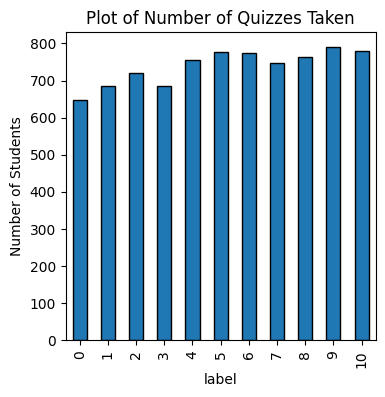

In [ ]:
values = df['NumberOfQuizzesTaken'].value_counts().sort_index()
values.plot(kind = 'bar', edgecolor='black', figsize = (6,6))
plt.title('Plot of Number of Quizzes Taken')
plt.xlabel('label')
plt.ylabel('Number of Students')
plt.show()

It seems that the majority of people take above 5 quizzes, while the minority take below.

In [12]:
# Check correlation between Quiz Scores and Number of Quizzes Taken
corr = df['QuizScores'].corr(df['NumberOfQuizzesTaken'])
print(corr)

-0.0023194963726316455


QuizScores and NumberOfQuizzesTaken aren't correlated, so we should keep them both.

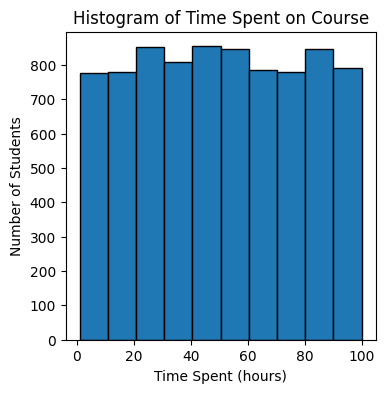

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(df['TimeSpentOnCourse'], bins=10, edgecolor='black')
plt.title('Histogram of Time Spent on Course')
plt.xlabel('Time Spent (hours)')
plt.ylabel('Number of Students')
plt.show()

This shows that there's approximately equal values in each bin, so this will be a useful feature.

Bottom half values: 3763
Top half values: 4360


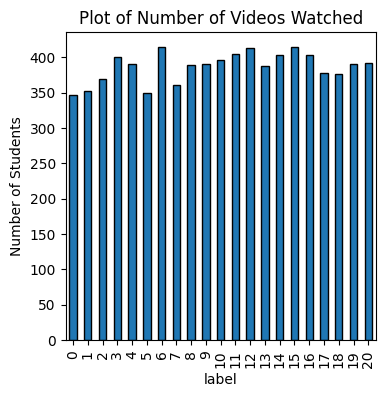

In [ ]:
values = df['NumberOfVideosWatched'].value_counts().sort_index()
values.plot(kind = 'bar', edgecolor='black', figsize = (6,6))
plt.title('Plot of Number of Videos Watched')
plt.xlabel('label')
plt.ylabel('Number of Students')


midpoint = len(values) // 2

bottom_half = values.iloc[:midpoint].sum()
top_half = values.iloc[midpoint:].sum()

print("Bottom half values:", bottom_half)
print("Top half values:", top_half)

While it's approximately equal, the top half of videos have slightly more students than the bottom half.

DeviceType
1    4065
0    4058
Name: count, dtype: int64


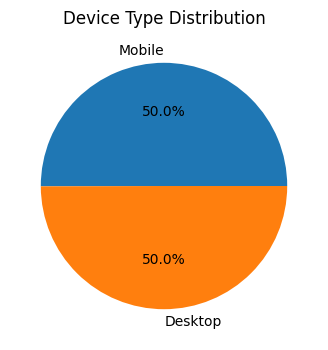

In [ ]:
values = df['DeviceType'].value_counts()

label_map = {0: 'Desktop', 1: 'Mobile'}
values.index = values.index.map(label_map)

print(df['DeviceType'].value_counts())

values.plot(kind = 'pie', figsize = (6,6), autopct='%1.1f%%')
plt.title('Device Type Distribution')
plt.ylabel('')
plt.show()

There are approximately equal devices, so this will be a useful feature.

Number of completions: 3568
Number of non-completions: 4555


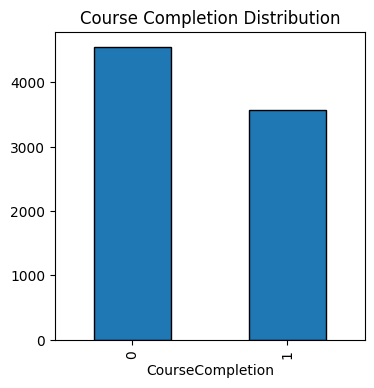

In [ ]:
values = df['CourseCompletion'].value_counts().sort_index()
values.plot(kind = 'bar', edgecolor='black', figsize = (6,6))
plt.title('Course Completion Distribution')

valueCounts = df['CourseCompletion'].value_counts()

print("Number of completions:", valueCounts[1])
print("Number of non-completions:", valueCounts[0])

The class distribution is roughly 56% non-completions and 44% completions, which is close enough to balanced that class weighting isn't necessary.

# Data Prep

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np

# Load the dataset again to ensure no changes were made
df = pd.read_csv(file_path)
df = df.drop_duplicates()

# Use all features but CompletionRate to prevent data leakage
features = ['CourseCategory', 'TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'DeviceType',
            'TimePerVideo' # Add or remove synthetic feature
            ]

# Synthetic feature (See below for explanation)
df['TimePerVideo'] = (df['TimeSpentOnCourse'] / df['NumberOfVideosWatched'].replace(0, np.nan)).fillna(0)

# One-hot encode categorical feature
df_encoded = pd.get_dummies(df[features], columns=['CourseCategory'])

# Seperate features and target variable
X = df_encoded
y = df['CourseCompletion']

# Split into validation and training sets
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

`CompletionRate` was excluded due to data leakage concerns since it directly reflects progress.

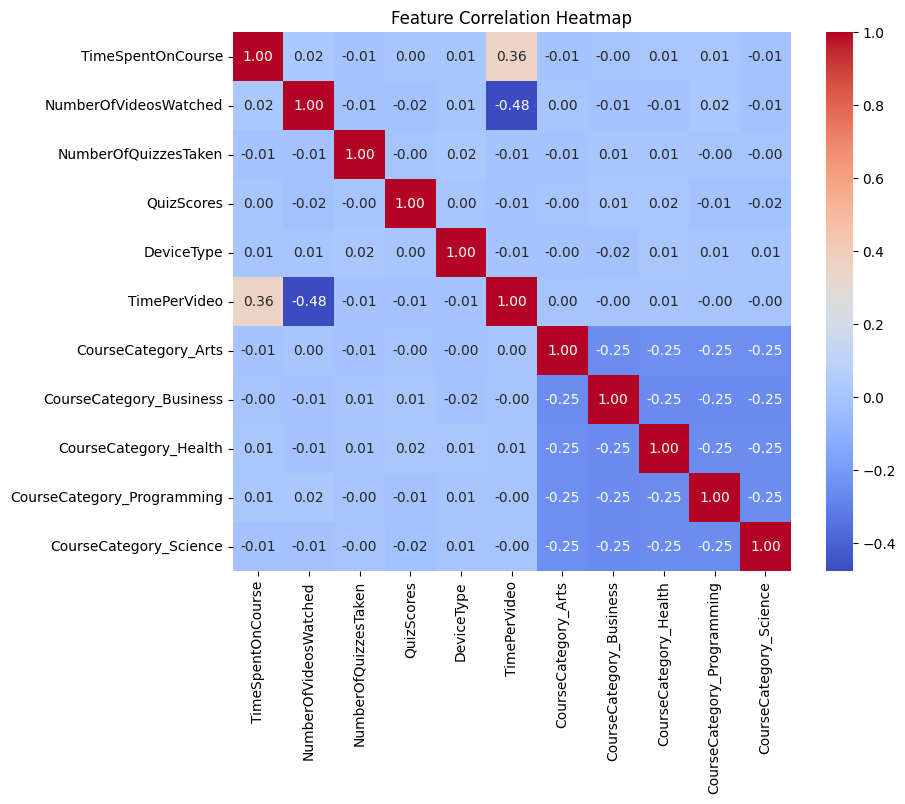

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df_copy = df_encoded.copy()

# Add synthetic features for testing
# df_copy['ScorePerQuiz'] = (df_copy['QuizScores'] / df_copy['NumberOfQuizzesTaken'].replace(0, np.nan)).fillna(0)
# df_copy['VideosPerQuiz'] = (df_copy['NumberOfVideosWatched'] / df_copy['NumberOfQuizzesTaken'].replace(0, np.nan)).fillna(0)
df_copy['TimePerVideo'] = (df_copy['TimeSpentOnCourse'] / df_copy['NumberOfVideosWatched'].replace(0, np.nan)).fillna(0)
# df_copy['TimePerQuiz'] = (df_copy['TimeSpentOnCourse'] / df_copy['NumberOfQuizzesTaken'].replace(0, np.nan)).fillna(0)
# df_copy['QuizScoreTimesVideos'] = df_copy['QuizScores'] * df_copy['NumberOfVideosWatched']

# For numeric features (after encoding categorical ones)
corr_matrix = df_copy.corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


The existing features seem useful, though out of the tested synthetic features, almost all overlap significantly with other features. The only one that seems useful is `TimePerVideo`, as it has the lowest correlation.

When using the other synthetic features along with `TimePerVideo`, it brought the accuracy and f1 scores down, so I have left them out of the final model. `TimePerVideo` likely captures depth of engagement per video, potentially reflecting attention span or pacing.

# Models

### Decision Tree

Best max_leaf_nodes: 5
CV Accuracy: 78.65%
CV F1: 68.72%


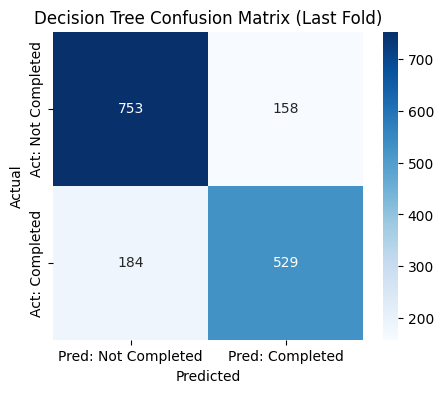

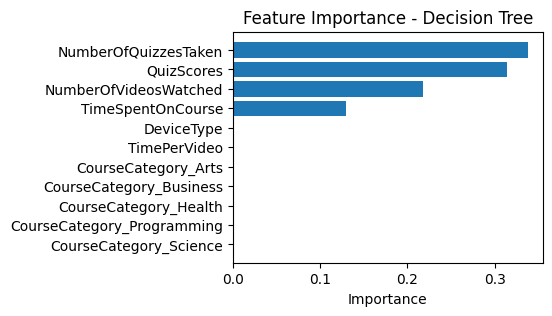

In [11]:
from sklearn.tree import DecisionTreeClassifier

tree_best_accuracy = 0
best_nodes = None
tree_best_f1 = 0

# Try each hyperparamter
for max_leaf_nodes in [5, 10, 20, 50, 100, 200, 500]:
    acc_scores = []
    f1_scores = []

    # Cross-validation loop
    for train_index, val_index in skf.split(X, y):
        train_X, val_X = X.iloc[train_index], X.iloc[val_index]
        train_y, val_y = y.iloc[train_index], y.iloc[val_index]

        model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=42)
        model.fit(train_X, train_y)
        val_preds = model.predict(val_X)

        acc_scores.append(accuracy_score(val_y, val_preds))
        f1_scores.append(f1_score(val_y, val_preds))

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)

    if avg_acc > tree_best_accuracy:
        tree_best_accuracy = avg_acc
        tree_best_f1 = avg_f1
        best_nodes = max_leaf_nodes

        # Save the best model for feature importance analysis later
        best_model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=42)
        best_model.fit(X, y)  # Retrain on full data

print(f"Best max_leaf_nodes: {best_nodes}")
print(f"CV Accuracy: {tree_best_accuracy*100:.2f}%")
print(f"CV F1: {tree_best_f1*100:.2f}%")

cm = confusion_matrix(val_y, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Not Completed', 'Pred: Completed'], 
            yticklabels=['Act: Not Completed', 'Act: Completed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Decision Tree Confusion Matrix (Last Fold)')
plt.show()

importances = best_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(4,3))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.show()

#### Feature Importance Analysis
The Decision Tree model ranked `NumberOfQuizzesTaken` and `QuizScores` as the most important features for predicting course completion, followed by `NumberOfVideosWatched` and `TimeSpentOnCourse`. Categorical features like `CourseCategory` and `DeviceType` had very low importance, suggesting that user engagement metrics mattered more than the type of course or device used.

#### Note
This is the only model to have this analysis as it is the highest performing model in F1 score.

### Random Forest

Best max_leaf_nodes: 10
CV Accuracy: 78.60%
CV F1: 68.86%


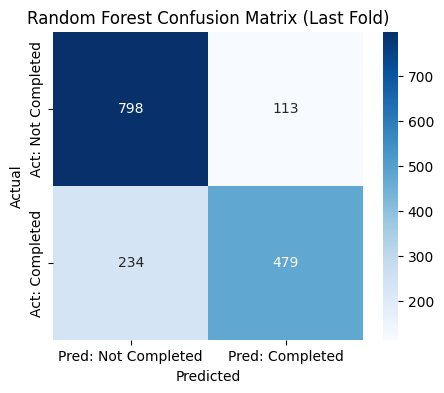

In [12]:
from sklearn.ensemble import RandomForestClassifier

forest_best_accuracy = 0
best_nodes = None
forest_best_f1 = 0

# Try each hyperparamter
for max_leaf_nodes in [5, 10, 20, 50, 100, 200, 500]:
    acc_scores = []
    f1_scores = []

    # Cross-validation loop
    for train_index, val_index in skf.split(X, y):
        train_X, val_X = X.iloc[train_index], X.iloc[val_index]
        train_y, val_y = y.iloc[train_index], y.iloc[val_index]

        model = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, random_state=42)
        model.fit(train_X, train_y)
        val_preds = model.predict(val_X)

        acc_scores.append(accuracy_score(val_y, val_preds))
        f1_scores.append(f1_score(val_y, val_preds))

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)

    if avg_acc > forest_best_accuracy:
        forest_best_accuracy = avg_acc
        forest_best_f1 = avg_f1
        best_nodes = max_leaf_nodes

print(f"Best max_leaf_nodes: {best_nodes}")
print(f"CV Accuracy: {forest_best_accuracy*100:.2f}%")
print(f"CV F1: {forest_best_f1*100:.2f}%")

cm = confusion_matrix(val_y, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Not Completed', 'Pred: Completed'], 
            yticklabels=['Act: Not Completed', 'Act: Completed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix (Last Fold)')
plt.show()

### ExtraTrees

Best max_leaf_nodes: 50
CV Accuracy: 77.13%
CV F1: 70.20%


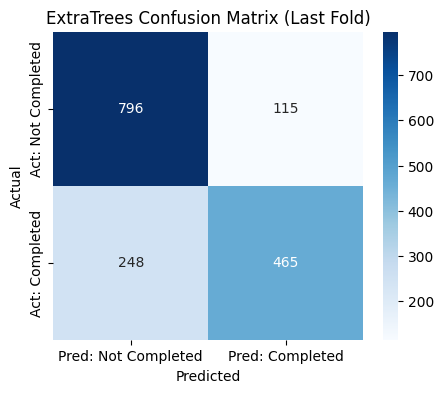

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

extra_best_accuracy = 0
best_nodes = None
extra_best_f1 = 0

# Try each hyperparamter
for max_leaf_nodes in [5, 10, 20, 50, 100, 200, 500]:
    acc_scores = []
    f1_scores = []

    # Cross-validation loop
    for train_index, val_index in skf.split(X, y):
        train_X, val_X = X.iloc[train_index], X.iloc[val_index]
        train_y, val_y = y.iloc[train_index], y.iloc[val_index]

        model = ExtraTreesClassifier(max_leaf_nodes=max_leaf_nodes, random_state=42)
        model.fit(train_X, train_y)
        val_preds = model.predict(val_X)

        acc_scores.append(accuracy_score(val_y, val_preds))
        f1_scores.append(f1_score(val_y, val_preds))

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)

    if avg_acc > extra_best_accuracy:
        extra_best_accuracy = avg_acc
        extra_best_f1 = avg_f1
        best_nodes = max_leaf_nodes

print(f"Best max_leaf_nodes: {best_nodes}")
print(f"CV Accuracy: {extra_best_accuracy*100:.2f}%")
print(f"CV F1: {extra_best_f1*100:.2f}%")

cm = confusion_matrix(val_y, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Not Completed', 'Pred: Completed'], 
            yticklabels=['Act: Not Completed', 'Act: Completed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('ExtraTrees Confusion Matrix (Last Fold)')
plt.show()

### GBDT

Best max_leaf_nodes: 5
CV Accuracy: 78.35%
CV F1: 69.53%


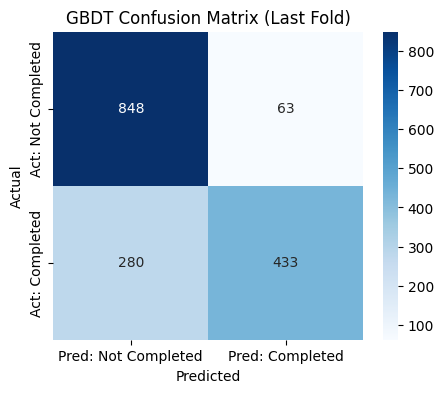

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt_best_accuracy = 0
best_nodes = None
gbdt_best_f1 = 0

# Try each hyperparamter
for max_leaf_nodes in [5, 10, 20, 50, 100, 200, 500]:
    acc_scores = []
    f1_scores = []

    # Cross-validation loop
    for train_index, val_index in skf.split(X, y):
        train_X, val_X = X.iloc[train_index], X.iloc[val_index]
        train_y, val_y = y.iloc[train_index], y.iloc[val_index]

        model = GradientBoostingClassifier(max_leaf_nodes=max_leaf_nodes, random_state=42)
        model.fit(train_X, train_y)
        val_preds = model.predict(val_X)

        acc_scores.append(accuracy_score(val_y, val_preds))
        f1_scores.append(f1_score(val_y, val_preds))

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)

    if avg_acc > gbdt_best_accuracy:
        gbdt_best_accuracy = avg_acc
        gbdt_best_f1 = avg_f1
        best_nodes = max_leaf_nodes

print(f"Best max_leaf_nodes: {best_nodes}")
print(f"CV Accuracy: {gbdt_best_accuracy*100:.2f}%")
print(f"CV F1: {gbdt_best_f1*100:.2f}%")

cm = confusion_matrix(val_y, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Not Completed', 'Pred: Completed'], 
            yticklabels=['Act: Not Completed', 'Act: Completed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('GBDT Confusion Matrix (Last Fold)')
plt.show()

### XGBoost

Best max_leaves: 20
CV Accuracy: 77.41%
CV F1: 73.16%


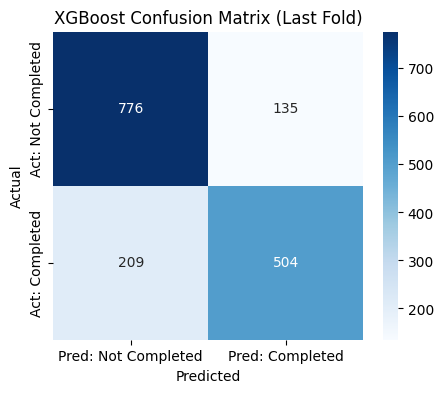

In [15]:
import xgboost as xgb

xgb_best_accuracy = 0
best_nodes = None
xgb_best_f1 = 0

# Try each hyperparamter
for max_leaves in [5, 10, 20, 50, 100, 200, 500]:
    acc_scores = []
    f1_scores = []

    # Cross-validation loop
    for train_index, val_index in skf.split(X, y):
        train_X, val_X = X.iloc[train_index], X.iloc[val_index]
        train_y, val_y = y.iloc[train_index], y.iloc[val_index]

        model = xgb.XGBClassifier(max_leaves=max_leaves, random_state=42, eval_metric='logloss')
        model.fit(train_X, train_y)
        val_preds = model.predict(val_X)

        acc_scores.append(accuracy_score(val_y, val_preds))
        f1_scores.append(f1_score(val_y, val_preds))

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)

    if avg_acc > xgb_best_accuracy:
        xgb_best_accuracy = avg_acc
        xgb_best_f1 = avg_f1
        best_nodes = max_leaves

print(f"Best max_leaves: {best_nodes}")
print(f"CV Accuracy: {xgb_best_accuracy*100:.2f}%")
print(f"CV F1: {xgb_best_f1*100:.2f}%")

cm = confusion_matrix(val_y, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Not Completed', 'Pred: Completed'], 
            yticklabels=['Act: Not Completed', 'Act: Completed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('XGBoost Confusion Matrix (Last Fold)')
plt.show()

### LightGBM

Best num_leaves: 50
CV Accuracy: 77.46%
CV F1: 73.21%

Classification Report (Last Fold):
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       911
           1       0.77      0.71      0.74       713

    accuracy                           0.78      1624
   macro avg       0.78      0.77      0.77      1624
weighted avg       0.78      0.78      0.78      1624

ROC AUC: 0.8746


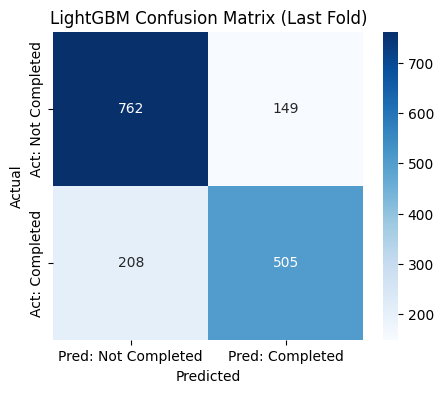

In [17]:
import lightgbm as lgb

light_best_accuracy = 0
best_nodes = None
light_best_f1 = 0

# Try each hyperparamter
for num_leaves in [20, 31, 50, 100, 200, 500]:
    acc_scores = []
    f1_scores = []

    # Cross-validation loop
    for train_index, val_index in skf.split(X, y):
        train_X, val_X = X.iloc[train_index], X.iloc[val_index]
        train_y, val_y = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMClassifier(num_leaves=num_leaves, random_state=42, verbose=-1)
        model.fit(train_X, train_y)
        val_preds = model.predict(val_X)

        acc_scores.append(accuracy_score(val_y, val_preds))
        f1_scores.append(f1_score(val_y, val_preds))

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)

    if avg_acc > light_best_accuracy:
        light_best_accuracy = avg_acc
        light_best_f1 = avg_f1
        best_nodes = num_leaves

print(f"Best num_leaves: {best_nodes}")
print(f"CV Accuracy: {light_best_accuracy*100:.2f}%")
print(f"CV F1: {light_best_f1*100:.2f}%\n")
print("Classification Report (Last Fold):")
print(classification_report(val_y, val_preds))

probs = model.predict_proba(val_X)[:, 1]
auc = roc_auc_score(val_y, probs)
print(f"ROC AUC: {auc:.4f}")

cm = confusion_matrix(val_y, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Not Completed', 'Pred: Completed'], 
            yticklabels=['Act: Not Completed', 'Act: Completed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('LightGBM Confusion Matrix (Last Fold)')
plt.show()

#### Classification Report Analysis
We can see that for Class 0 (*did not* complete), the precision is slightly higher, but the recall is significantly higher than Class 1 (*did* complete). This means that the model misses some actual completions, as the recall is lower, but when it does predict a completion, it is usually right. Additionally, the model does a good job at identifying non-completions and rarely mislabels completions as non-completions.

#### AUC ROC Analysis
The AUC ROC value of .8746 means that the model is performing well when distinguishing between the two classes.

#### Note
This is the only model to have this analysis as it is the highest performing model in F1 score.

### CatBoost

Best Depth: 20
CV Accuracy: 77.43%
CV F1: 72.83%


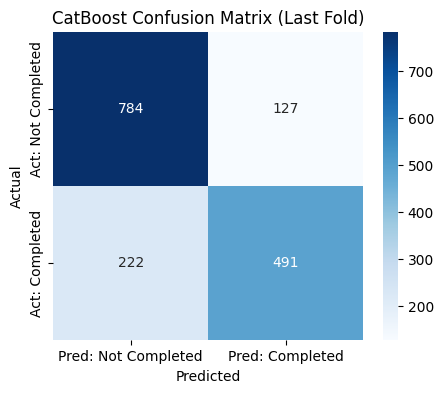

In [19]:
from catboost import CatBoostClassifier

cat_best_accuracy = 0
best_nodes = None
cat_best_f1 = 0

# Try each hyperparamter
for depth in [5, 10, 20, 50, 100, 200]:
    acc_scores = []
    f1_scores = []

    # Cross-validation loop
    for train_index, val_index in skf.split(X, y):
        train_X, val_X = X.iloc[train_index], X.iloc[val_index]
        train_y, val_y = y.iloc[train_index], y.iloc[val_index]

        model = CatBoostClassifier(depth=depth, random_state=42, verbose=0, grow_policy='Lossguide', early_stopping_rounds=20)
        model.fit(train_X, train_y)
        val_preds = model.predict(val_X)

        acc_scores.append(accuracy_score(val_y, val_preds))
        f1_scores.append(f1_score(val_y, val_preds))

    avg_acc = np.mean(acc_scores)
    avg_f1 = np.mean(f1_scores)

    if avg_acc > cat_best_accuracy:
        cat_best_accuracy = avg_acc
        cat_best_f1 = avg_f1
        best_nodes = depth

print(f"Best Depth: {best_nodes}")
print(f"CV Accuracy: {cat_best_accuracy*100:.2f}%")
print(f"CV F1: {cat_best_f1*100:.2f}%")

cm = confusion_matrix(val_y, val_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: Not Completed', 'Pred: Completed'], 
            yticklabels=['Act: Not Completed', 'Act: Completed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('CatBoost Confusion Matrix (Last Fold)')
plt.show()

# Analysis

In [16]:
model_accuracy = {
    'Decision Tree': tree_best_accuracy,
    'Random Forest': forest_best_accuracy,
    'ExtraTrees': extra_best_accuracy,
    'GBDT': gbdt_best_accuracy,
    'XGBoost': xgb_best_accuracy,
    'LightGBM': light_best_accuracy,
    'CatBoost': cat_best_accuracy
}

# Find model with the best accuracy
best_model_accuracy = max(model_accuracy, key=model_accuracy.get)
best_accuracy = model_accuracy[best_model_accuracy]

print(f"Model with the best Accuracy: {best_model_accuracy} with {best_accuracy*100:.2f}%")

model_f1 = {
    'Decision Tree': tree_best_f1,
    'Random Forest': forest_best_f1,
    'ExtraTrees': extra_best_f1,
    'GBDT': gbdt_best_f1,
    'XGBoost': xgb_best_f1,
    'LightGBM': light_best_f1,
    'CatBoost': cat_best_f1
}

# Find model with the best accuracy
best_model_f1 = max(model_f1, key=model_f1.get)
best_f1_score = model_f1[best_model_f1]

print(f"Model with the best F1 Score: {best_model_f1} with {best_f1_score*100:.2f}%")

Model with the best Accuracy: Decision Tree with 78.65%
Model with the best F1 Score: LightGBM with 73.21%


Note: The above information is done with the synthetic feature `TimePerVideo`

### Summary

Without using `TimePerVideo`, the best model for:
- Accuracy: Random Forest with 78.73%
- F1 Score: LightGBM with 72.60%

With using `TimePerVideo`, the best model for:
- Accuracy: Decision Tree with 78.65%
- F1 Score: LightGBM with 73.21%

Using `TimePerVideo` with the LightGBM Classifier increased the F1 Score by .61%, but not using `TimePerVideo` with the Random Forest Classifier increased the Accuracy by .08%.

Based on metric priorities, we selected the LightGBM Classifier with `TimePerVideo` included. It has consistent results, and handles complexity well. While Random Forest had the highest accuracy at 78.73% without TimePerVideo, LightGBM with the synthetic feature had the best F1 at 73.21% and strong AUC, making it the overall best-performing model for our goal.